In [11]:
import numpy as np

In [12]:
data = open("HP1_shorten.txt").read().lower()

In [13]:
words = data.split()
len(words)

21123

In [14]:
split_index = int(0.8 * len(words))

train_data = words[:split_index]
test_data = words[split_index:]

In [15]:
len(set(train_data)-set(test_data))

3197

In [16]:
len(set(test_data)-set(train_data))

813

In [17]:
word_set = set(words)
word_set
word_to_idx = {w:i for i, w in enumerate(word_set)}
idx_to_word = {i:w for i, w in enumerate(word_set)}

In [18]:
word_size = len(word_set)
word_size

4838

In [19]:
def oneHotEncode(text):
    output = np.zeros((word_size, 1))
    output[word_to_idx[text]] = 1

    return output

# Xavier Normalized Initialization
def initWeights(input_size, output_size):
    return np.random.uniform(-1, 1, (output_size, input_size)) * np.sqrt(6 / (input_size + output_size))

##### Activation Functions #####
def sigmoid(input, derivative = False):
    if derivative:
        return input * (1 - input)

    return 1 / (1 + np.exp(-input))

def tanh(input, derivative = False):
    if derivative:
        return 1 - input ** 2

    return np.tanh(input)

def softmax(input):
    return np.exp(input) / np.sum(np.exp(input))

##### Long Short-Term Memory Network Class #####
class LSTM:
    def __init__(self, input_size, hidden_size, output_size, num_epochs, learning_rate):
        # Hyperparameters
        self.learning_rate = learning_rate
        self.hidden_size = hidden_size
        self.num_epochs = num_epochs

        # Forget Gate
        self.wf = initWeights(input_size, hidden_size)
        self.bf = np.zeros((hidden_size, 1))

        # Input Gate
        self.wi = initWeights(input_size, hidden_size)
        self.bi = np.zeros((hidden_size, 1))

        # Candidate Gate
        self.wc = initWeights(input_size, hidden_size)
        self.bc = np.zeros((hidden_size, 1))

        # Output Gate
        self.wo = initWeights(input_size, hidden_size)
        self.bo = np.zeros((hidden_size, 1))

        # Final Gate
        self.wy = initWeights(hidden_size, output_size)
        self.by = np.zeros((output_size, 1))

    # Reset Network Memory
    def reset(self):
        self.concat_inputs = {}

        self.hidden_states = {-1:np.zeros((self.hidden_size, 1))}
        self.cell_states = {-1:np.zeros((self.hidden_size, 1))}

        self.activation_outputs = {}
        self.candidate_gates = {}
        self.output_gates = {}
        self.forget_gates = {}
        self.input_gates = {}
        self.outputs = {}

    # Forward Propogation
    def forward(self, inputs):
        self.reset()

        outputs = []
        for q in range(len(inputs)):
            self.concat_inputs[q] = np.concatenate((self.hidden_states[q - 1], inputs[q]))

            self.forget_gates[q] = sigmoid(np.dot(self.wf, self.concat_inputs[q]) + self.bf)
            self.input_gates[q] = sigmoid(np.dot(self.wi, self.concat_inputs[q]) + self.bi)
            self.candidate_gates[q] = tanh(np.dot(self.wc, self.concat_inputs[q]) + self.bc)
            self.output_gates[q] = sigmoid(np.dot(self.wo, self.concat_inputs[q]) + self.bo)

            self.cell_states[q] = self.forget_gates[q] * self.cell_states[q - 1] + self.input_gates[q] * self.candidate_gates[q]
            self.hidden_states[q] = self.output_gates[q] * tanh(self.cell_states[q])

            outputs += [np.dot(self.wy, self.hidden_states[q]) + self.by]

        return outputs

    # Backward Propogation
    def backward(self, errors, inputs):
        d_wf, d_bf = 0, 0
        d_wi, d_bi = 0, 0
        d_wc, d_bc = 0, 0
        d_wo, d_bo = 0, 0
        d_wy, d_by = 0, 0

        dh_next, dc_next = np.zeros_like(self.hidden_states[0]), np.zeros_like(self.cell_states[0])
        for q in reversed(range(len(inputs))):
            error = errors[q]

            # Final Gate Weights and Biases Errors
            d_wy += np.dot(error, self.hidden_states[q].T)
            d_by += error

            # Hidden State Error
            d_hs = np.dot(self.wy.T, error) + dh_next

            # Output Gate Weights and Biases Errors
            d_o = tanh(self.cell_states[q]) * d_hs * sigmoid(self.output_gates[q], derivative = True)
            d_wo += np.dot(d_o, inputs[q].T)
            d_bo += d_o

            # Cell State Error
            d_cs = tanh(tanh(self.cell_states[q]), derivative = True) * self.output_gates[q] * d_hs + dc_next

            # Forget Gate Weights and Biases Errors
            d_f = d_cs * self.cell_states[q - 1] * sigmoid(self.forget_gates[q], derivative = True)
            d_wf += np.dot(d_f, inputs[q].T)
            d_bf += d_f

            # Input Gate Weights and Biases Errors
            d_i = d_cs * self.candidate_gates[q] * sigmoid(self.input_gates[q], derivative = True)
            d_wi += np.dot(d_i, inputs[q].T)
            d_bi += d_i

            # Candidate Gate Weights and Biases Errors
            d_c = d_cs * self.input_gates[q] * tanh(self.candidate_gates[q], derivative = True)
            d_wc += np.dot(d_c, inputs[q].T)
            d_bc += d_c

            # Concatenated Input Error (Sum of Error at Each Gate!)
            d_z = np.dot(self.wf.T, d_f) + np.dot(self.wi.T, d_i) + np.dot(self.wc.T, d_c) + np.dot(self.wo.T, d_o)

            # Error of Hidden State and Cell State at Next Time Step
            dh_next = d_z[:self.hidden_size, :]
            dc_next = self.forget_gates[q] * d_cs

        for d_ in (d_wf, d_bf, d_wi, d_bi, d_wc, d_bc, d_wo, d_bo, d_wy, d_by):
            np.clip(d_, -1, 1, out = d_)

        self.wf += d_wf * self.learning_rate
        self.bf += d_bf * self.learning_rate

        self.wi += d_wi * self.learning_rate
        self.bi += d_bi * self.learning_rate

        self.wc += d_wc * self.learning_rate
        self.bc += d_bc * self.learning_rate

        self.wo += d_wo * self.learning_rate
        self.bo += d_bo * self.learning_rate

        self.wy += d_wy * self.learning_rate
        self.by += d_by * self.learning_rate

    # Train
    def train(self, inputs, labels):
        inputs = [oneHotEncode(input) for input in inputs]

        loss = []
        average_loss = []
        accuracy_list = []

        for _ in range(self.num_epochs):
            predictions = self.forward(inputs)

            errors = []
            l = 0
            accuracy = 0
            for q in range(len(predictions)):
                errors += [-softmax(predictions[q])]
                errors[-1][word_to_idx[labels[q]]] += 1

                l += -np.log(softmax(predictions[q])[word_to_idx[labels[q]]])

                prediction = str(idx_to_word[np.random.choice([*range(word_size)], p = softmax(predictions[q].reshape(-1)))])
                if prediction == labels[q]:
                    accuracy += 1

            loss.append(l)
            average_loss.append(l/len(predictions))
            accuracy_list.append((accuracy/len(labels))*100)

            if (_ == 0) | ((_+1)%20==0):
                print(f"Epoch: {_+1}, Loss: {loss[_]}, Average Loss: {average_loss[_]}, Accuracy: {accuracy_list[_]} \n")

            self.backward(errors, self.concat_inputs)

        return loss, average_loss, accuracy_list

    # Test
    def test(self, inputs, labels):
        accuracy = 0
        predictions = self.forward([oneHotEncode(input) for input in inputs])

        output = []
        for q in range(len(labels)):
            prediction = str(idx_to_word[np.random.choice([*range(word_size)], p = softmax(predictions[q].reshape(-1)))])

            output.append(prediction)

            if prediction == labels[q]:
                accuracy += 1

        print(f'Ground Truth:\nt{labels}\n')
        print(f'Predictions:\nt{output}\n')

        print(f'Accuracy: {round(accuracy * 100 / len(labels), 2)}%')

In [20]:
# Initialize Network
hidden_size = 25
lstm = LSTM(input_size = word_size + hidden_size, hidden_size = hidden_size, output_size = word_size, num_epochs = 300, learning_rate = 0.1)

##### Training #####
train_X, train_y = train_data[:-1], train_data[1:]
train_loss_sum, train_loss_mean, train_accuracy = lstm.train(train_X, train_y)

Epoch: 1, Loss: [143358.88465006], Average Loss: [8.48428032], Accuracy: 0.011836420666390485 

Epoch: 20, Loss: [114286.73613581], Average Loss: [6.76372943], Accuracy: 0.5089660886547909 

Epoch: 40, Loss: [111134.29945093], Average Loss: [6.57716159], Accuracy: 0.7042670296502338 

Epoch: 60, Loss: [102793.3150958], Average Loss: [6.0835246], Accuracy: 1.2369059596378054 

Epoch: 80, Loss: [95843.27705322], Average Loss: [5.67220673], Accuracy: 2.0713736166183345 

Epoch: 100, Loss: [90103.76445469], Average Loss: [5.3325303], Accuracy: 2.538912232940759 

Epoch: 120, Loss: [82318.86143757], Average Loss: [4.87180336], Accuracy: 3.4207255725868495 

Epoch: 140, Loss: [75815.6928239], Average Loss: [4.48693217], Accuracy: 4.462330591229213 

Epoch: 160, Loss: [70035.00672018], Average Loss: [4.144819], Accuracy: 5.941883174528022 

Epoch: 180, Loss: [65028.61796997], Average Loss: [3.84853039], Accuracy: 7.776528377818548 

Epoch: 200, Loss: [61676.58214915], Average Loss: [3.6501498

In [21]:
lstm.test(train_data[:-1], train_data[1:])

Ground Truth:
t['potter', 'and', 'the', "sorcerer's", 'stone', 'chapter', 'one', 'the', 'boy', 'who', 'lived', 'mr.', 'and', 'mrs.', 'dursley,', 'of', 'number', 'four,', 'privet', 'drive,', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal,', 'thank', 'you', 'very', 'much.', 'they', 'were', 'the', 'last', 'people', "you'd", 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious,', 'because', 'they', 'just', "didn't", 'hold', 'with', 'such', 'nonsense.', 'mr.', 'dursley', 'was', 'the', 'director', 'of', 'a', 'firm', 'called', 'grunnings,', 'which', 'made', 'drills.', 'he', 'was', 'a', 'big,', 'beefy', 'man', 'with', 'hardly', 'any', 'neck,', 'although', 'he', 'did', 'have', 'a', 'very', 'large', 'mustache.', 'mrs.', 'dursley', 'was', 'thin', 'and', 'blonde', 'and', 'had', 'nearly', 'twice', 'the', 'usual', 'amount', 'of', 'neck,', 'which', 'came', 'in', 'very', 'useful', 'as', 'she', 'spent', 'so', 'much', 'of', 'her', 'time', 'craning'

In [22]:
test_X, test_y = test_data[:-1], test_data[1:]
lstm.test(test_X, test_y)

Ground Truth:
t['tickets.', 'people', 'stared', 'more', 'than', 'ever', 'on', 'the', 'train.', 'hagrid', 'took', 'up', 'two', 'seats', 'and', 'sat', 'knitting', 'what', 'looked', 'like', 'a', 'canary-yellow', 'circus', 'tent.', '"still', 'got', 'yer', 'letter,', 'harry?"', 'he', 'asked', 'as', 'he', 'counted', 'stitches.', 'harry', 'took', 'the', 'parchment', 'envelope', 'out', 'of', 'his', 'pocket.', '"good,"', 'said', 'hagrid.', '"there\'s', 'a', 'list', 'there', 'of', 'everything', 'yeh', 'need."', 'harry', 'unfolded', 'a', 'second', 'piece', 'of', 'paper', 'he', "hadn't", 'noticed', 'the', 'night', 'before,', 'and', 'read:', 'hogwarts', 'school', 'of', 'witchcraft', 'and', 'wizardry', 'uniform', 'first-year', 'students', 'will', 'require:', '1.', 'three', 'sets', 'of', 'plain', 'work', 'robes', '(black)', '2.', 'one', 'plain', 'pointed', 'hat', '(black)', 'for', 'day', 'wear', '3.', 'one', 'pair', 'of', 'protective', 'gloves', '(dragon', 'hide', 'or', 'similar)', '4.', 'one', 'wint

Text(0, 0.5, 'training loss')

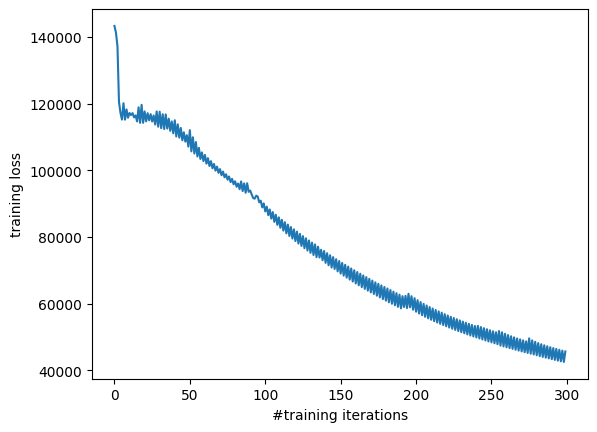

In [23]:
import pylab as plt

plt.plot([i for i in range(len(train_loss_sum))], train_loss_sum)
plt.xlabel("#training iterations")
plt.ylabel("training loss")

Text(0, 0.5, 'mean training loss')

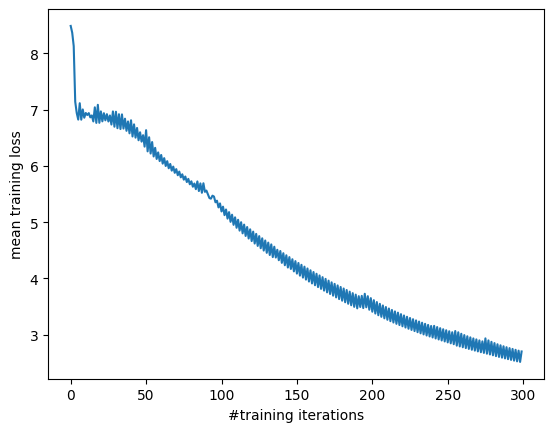

In [24]:
plt.plot([i for i in range(len(train_loss_mean))], train_loss_mean)
plt.xlabel("#training iterations")
plt.ylabel("mean training loss")

In [25]:
import random
test_data_shuffled = np.copy(test_data)
random.shuffle(test_data_shuffled)

lstm.test(test_data_shuffled[:-1], test_data_shuffled[1:])

Ground Truth:
t['jelly-legs,' 'a' 'sort' ... 'seen' "sayin'" 'cart']

Predictions:
t["dudley's", 'of', 'little', 'look', 'leather', 'his', 'thought,', 'mommy', 'they', 'passed,', 'dudley.', 'aunt', 'get', 'but', 'at', '"about', 'all', 'have', 'been', "minutes'", 'hole', 'he', '--', 'at', "don't", 'he', 'was', 'get', 'was', 'going.', 'of', 'there?"', 'made', 'to', 'get', 'unknown', 'it', 'way.', 'and', 'to', 'and', 'opened', 'eleven', '"but', "dudley's", 'him', 'you', 'privet', 'took', 'it', 'this', 'be', 'and', 'and', 'unfolding', 'it', 'she', 'his', 'he', 'in', 'as', "haven't", 'been', 'hoped)', 'harry.', 'as', 'they', 'off', 'with', 'with', 'how', 'harry', 'case', 'half', 'through', 'hogwarts!', 'weather.', 'seemed', 'in', 'he', 'then', 'went', 'been', 'than', 'set', 'missed', 'this', 'his', 'while', 'jumped;', 'day.', 'he', 'to', 'in', 'him...', 'of', 'piers', 'in', 'into', 'you', 'number', 'unusual', 'had', 'open,', 'same', 'this', 'harry', 'back', 'potter', 'back', 'to', 'and', 't

In [12]:
test_X, test_y = test_data[:-1], test_data[1:]
lstm.test(test_X, test_y)

Ground Truth:
t['tickets.', 'people', 'stared', 'more', 'than', 'ever', 'on', 'the', 'train.', 'hagrid', 'took', 'up', 'two', 'seats', 'and', 'sat', 'knitting', 'what', 'looked', 'like', 'a', 'canary-yellow', 'circus', 'tent.', '"still', 'got', 'yer', 'letter,', 'harry?"', 'he', 'asked', 'as', 'he', 'counted', 'stitches.', 'harry', 'took', 'the', 'parchment', 'envelope', 'out', 'of', 'his', 'pocket.', '"good,"', 'said', 'hagrid.', '"there\'s', 'a', 'list', 'there', 'of', 'everything', 'yeh', 'need."', 'harry', 'unfolded', 'a', 'second', 'piece', 'of', 'paper', 'he', "hadn't", 'noticed', 'the', 'night', 'before,', 'and', 'read:', 'hogwarts', 'school', 'of', 'witchcraft', 'and', 'wizardry', 'uniform', 'first-year', 'students', 'will', 'require:', '1.', 'three', 'sets', 'of', 'plain', 'work', 'robes', '(black)', '2.', 'one', 'plain', 'pointed', 'hat', '(black)', 'for', 'day', 'wear', '3.', 'one', 'pair', 'of', 'protective', 'gloves', '(dragon', 'hide', 'or', 'similar)', '4.', 'one', 'wint

Text(0, 0.5, 'training loss')

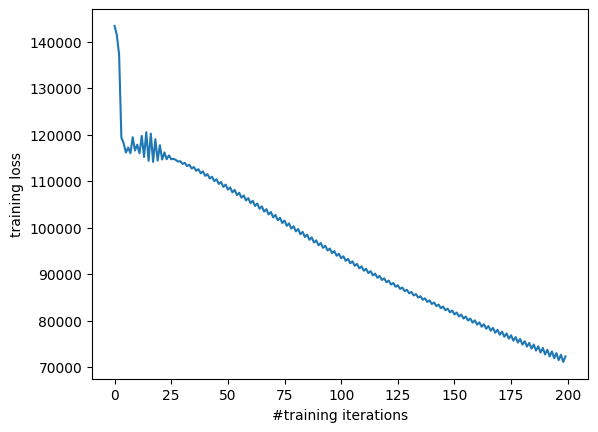

In [13]:
import pylab as plt

plt.plot([i for i in range(len(train_loss_sum))], train_loss_sum)
plt.xlabel("#training iterations")
plt.ylabel("training loss")

Text(0, 0.5, 'mean training loss')

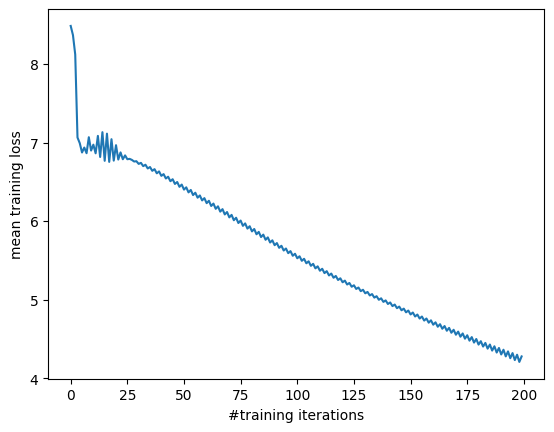

In [14]:
plt.plot([i for i in range(len(train_loss_mean))], train_loss_mean)
plt.xlabel("#training iterations")
plt.ylabel("mean training loss")

In [15]:
import random
train_data_shuffled = np.copy(train_data)
random.shuffle(train_data_shuffled)

lstm.test(train_data_shuffled[:-1], train_data_shuffled[1:])

Ground Truth:
t["haven't" 'someone' 'shock.' ... 'her' 'bathroom.' 'rumor']

Predictions:
t['gleamed', 'where', 'questions', 'as', 'a', 'and', '--', 'long', 'the', 'another', 'managed', 'down,', 'he', 'head,', 'vernon', 'fat', 'day.', 'of', 'aunt', 'coat.', 'addressed', 'as', 'the', 'the', 'at', 'dursleys', 'was', 'on', 'he', 'his', 'he', 'for', 'to', 'his', 'of', 'the', 'a', 'lotta', '--', 'the', 'scared', "anythin'", 'the', 'made', 'starting', 'of', 'upset', 'grew', 'of', 'and', 'just', 'reason', 'it', 'for', 'ever', 'younger,', 'i', 'door,', 'stare.', 'new', 'had', 'the', '"ah,', 'had', 'of', 'of', 'window.', '"exactly,"', 'the', 'the', 'muttered,', 'big', 'garden', 'if', 'paper.', "didn't", 'dursley,', 'on', 'drive,', 'on', 'bronze', 'man', 'mcgonagall', 'when', 'he', 'next', 'why,', 'said', 'had', 'gave', 'seemed', 'to', 'the', 'himself', 'on', 'hagrid', 'ter', 'just', 'of', 'whispering', 'school', 'fashion.', 'his', 'killed', 'side', 'said', 'boy', 'he', 'to', 'to', 'stars', 'ter